In [1]:
import copy
import gzip
import itertools
import json
import pickle
import os
import random
import re
import threading
import time
from collections import Counter
import glob

import h5py
import clip
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from nltk.tokenize import PunktSentenceTokenizer
from numba import jit
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import pathlib
from nltk.tokenize import PunktSentenceTokenizer
random.seed(25)
np.random.seed(25)
def instruction_cut_clip(episodes, append_dot=False, keep_subs=True, refine=False, split_func=None, lower_all=False):
    """
    Params:
        episodes: a dataset list, [{"instruction_text":""}]
        append_dot: whether to add a "." at the end of sub-instructions
        keep_subs: whether to keep sub-instruction text after processing
        refine: whether to use proposed refine processing
        split_func: the function used to cut instructions, default is `nltk.sent_tokenize`
        lower_all: whether to lower all characters in sub-instructions.
    Return:
        train_data with "sub_instruction_tokens" and "sub_instruction"
    """
    if split_func is None:
        split_func = nltk.sent_tokenize
    print(split_func)
    train_data = copy.deepcopy(episodes)
    # pre process
    char_pattern = re.compile(r"[a-zA-Z]")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        inst = inst.strip()
        start_idx = 0
        while not char_pattern.search(inst[start_idx]):
            start_idx += 1
        inst = inst[start_idx:]
        if lower_all:
            inst = inst.lower()
        train_data[i]["instruction_text"] = inst.replace("...", ".").replace("..", ".").replace(".",". ").replace("  ", " ")
    
    # cut by nltk
    pattern = re.compile(r"\r\n")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        res = []
        now = pattern.split(inst)
        for v in now:
            res.extend(split_func(v))
        train_data[i]["sub_instruction"] = [piece.strip() for piece in res if piece.strip()]
    # refine
    if refine:
        punctuation_list = [",", "."]
        char_pattern = re.compile(r"[a-zA-Z]+")
        def judge_verb(word):
            const_verbs = ["wait", "turn", "walk", "stop"]
            if "VB" in word[1]:
                return True
            if word[0] in const_verbs:
                return True
            return False
        for i, item in enumerate(tqdm(train_data)):
            new_sub = []
            for k, piece in enumerate(item["sub_instruction"]):
                word_list = nltk.pos_tag(nltk.word_tokenize(piece))
                tmp = ""
                for x, word in enumerate(word_list):
                    if (word[0].lower()=="and" or word[0]=="," or word[0].lower()=="then") and (x+1<len(word_list) and judge_verb(word_list[x+1])):
                        if tmp and char_pattern.search(tmp):
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                            
                    elif (word[0]=="and" or word[0]==",") and (x+1<len(word_list) and word_list[x+1][0]=="then"):
                        if tmp:
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                    else:
                        if not tmp or word[0] in punctuation_list:
                            tmp+=word[0]
                        else:
                            tmp+=(" "+word[0])
                if tmp:
                    new_sub.append(tmp)
            train_data[i]["sub_instruction"] = new_sub
    
    # post process and generate tokens
    char_pattern = re.compile(r"[a-zA-Z]")
    max_len = 0
    pad_index = 0
    pad_len = 86 # 0.09%
    sub_pad_len = 77 # 0.05%
    sub_num = 12 # 0.04%
    useless_sub = [pad_index]*sub_pad_len
    sub_split_index = -1
    for i, item in enumerate(tqdm(train_data)):
        tokens_all = []
        tokens_split = []
        for k, piece in enumerate(item["sub_instruction"]):
            piece = piece.strip()
            assert piece
            idx = len(piece)-1
            while idx>=0 and piece[idx] in [".", ","]:
                idx -= 1
            if append_dot:
                piece = piece[0:(idx+1)]+"."
            else:
                piece = piece[0:(idx+1)]
            piece = piece.replace("``", "\"").replace("''", "\"")
            train_data[i]["sub_instruction"][k] = piece
            piece_tokens = clip.tokenize(piece, truncate=True).squeeze(0).tolist()
            tokens_split.append(piece_tokens)
        if len(tokens_split)>sub_num:
            tokens_split = tokens_split[0:sub_num]
        tokens_split.extend([useless_sub]*(sub_num-len(tokens_split)))
        
        train_data[i]["instruction_tokens"] = clip.tokenize(item["instruction_text"], truncate=True, context_length=77).squeeze(0).tolist()
        train_data[i]["sub_instruction_tokens"] = tokens_split
        if not keep_subs:
            del item["sub_instruction"]
    return train_data

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
def random_chunks(lst, left, right):
    """Yield successive n-sized chunks from lst."""
    i = 0
    n = len(lst)
    while i<n:
        k = random.randint(left,right)
        yield lst[i:min(i+k, n)]
        i += k

In [4]:
import json
# extend
from pathlib import Path
import shutil
DATA_FOLDER = Path("/root/autodl-tmp/data/vlntj-ce-extend")
# for i in range(13):
#     old_path = DATA_FOLDER / str(i)
#     new_path = DATA_FOLDER / str(i+13)
#     shutil.copytree(old_path, new_path)
# for i in range(13):
#     old_path = DATA_FOLDER / str(i)
#     new_path = DATA_FOLDER / str(i+13*2)
#     shutil.copytree(old_path, new_path)
instructions = [
    ## Part1
    "Move forward to the black box. Turn right and forward to the whiteboard. Walk into the office area. Turn right and stop before black chairs.", # 0
    "Turn left and cross several boxes on your right. Move close to the water dispenser and the printer, then stop.", # 1
    "Turn left. Move forward down the hallway until you see the guitar and blackboard. Head towards the guitar and stop.", # 2
    "Walk into the storage area. Walk right past the box. Wait before the cabinets.", # 3
    "Forward along the corridor. Turn right into the office. Forward and take a left at the shelf. Wait before the refrigerator.", # 4
    "Walk past several chairs on your left. Continue past the trash bin. Stop by the bookshelf.", # 5
    "Start from the office with a barrel-loaded water. Take a left and walk out the door into the corridor. Find a door on the right and stop.", # 6
    "Move forward into the lobby. Turn left and exit the lobby with a large door. Walk to the bulletin board and stop.", # 7
    "Enter the mechanical studio. Turn left and move forward alongside the green table. Stop before chairs.", # 8
    "Walk past the area towards a blue car. Wait before the shelf with many boxes.", # 9
    "Face the green workbench. Turn left and walk out the door. Walk through the red extinguisher and the blue umbrella. Stop by the door.", # 10
    "See the blackboard, move forward a few steps. Turn left until you see a large television. Wait there.", # 11
    "Walk into the office area and stop before the whiteboard around cabinets.", # 12

    ## Part2 (DeepL)
    "Proceed to the black box, then turn right and proceed to the whiteboard. Enter the office area and turn right, stopping in front of the black chair.", # 0
    "Turn left and pass a couple of boxes on the right. Approach the water dispenser and the printer, then stop.", # 1
    "Turn left and follow the hallway until you find the guitar and the blackboard. Walk towards the guitar and stop.", # 2
    "Enter the storage area and walk past the boxes. Pause in front of the cabinet.", # 3
    "Proceed down the hallway, turn right into the office, continue forward and turn left on the shelf. Stop in front of the refrigerator.", # 4
    "Walk past a couple chairs on the left, then continue past the trash can. Stop by the bookshelf.", # 5
    "Start in the office containing the bucket of water. Turn left, go out the door and into the hallway. Find a door on the right and stop.", # 6
    "Go forward into the lobby, turn left, and exit through a large door. Walk to the bulletin board and stop.", # 7
    "Enter the mechanical studio, turn left and walk forward along the green table. Stop in front of the chair.", # 8
    "Walk through the area towards a blue car and wait in front of a shelf containing many boxes.", # 9
    "Facing the green workbench, turn left, then walk out the door. Go through the red fire extinguisher and blue umbrella, then stop by the door.", # 10
    "When you spot the blackboard, walk forward a few steps and then turn left until you see a large television. Wait there.", # 11
    "Enter the office area and stop at the whiteboard around the cabinet.", # 12

    
    ## Part3 (GPT)
    "Proceed towards the black box, then turn right and proceed towards the whiteboard. Enter the office area and stop before the black chairs.", # 0
    "Turn left and pass several boxes on your right. Approach the water dispenser and the printer, then stop.", # 1
    "Turn left and progress down the hallway until you spot the guitar and blackboard. Move towards the guitar and stop.", # 2
    "Enter the storage area. Walk past the box to your right. Halt before the cabinets.", # 3
    "Proceed along the corridor. Turn right into the office. Continue forward and take a left at the shelf. Stop before the refrigerator.", # 4
    "Pass several chairs on your left. Keep going past the trash bin. Stop by the bookshelf.", # 5
    "Start from the office with the barrel-loaded water. Turn left and walk out the door into the corridor. Locate a door on the right and stop.", # 6
    "Advance into the lobby. Turn left and exit the lobby through a large door. Walk to the bulletin board and stop.", # 7
    "Enter the mechanical studio. Turn left and advance alongside the green table. Stop before the chairs.", # 8
    "Walk past the area towards the blue car. Halt before the shelf with numerous boxes.", # 9
    "Face the green workbench. Turn left and walk out the door. Proceed through the red extinguisher and the blue umbrella. Stop by the door.", # 10
    "Spot the blackboard, take a few steps forward. Turn left until you see a large television. Wait there.", # 11
    "Walk into the office area and halt before the whiteboard near the cabinets.", # 12
]
# with open("instructions.json", "w") as f:
#     f.write(json.dumps(instructions, indent=2))
# with open(DATA_FOLDER/"instructions.json","r") as f:
#     instructions = json.loads(f.read())
sub_data = instruction_cut_clip([{"instruction_text": v} for v in instructions], refine=True, append_dot=False, split_func=nltk.sent_tokenize, keep_subs=True)
sub_instructions = [v["sub_instruction"] for v in sub_data]
for i in tqdm(range(len(instructions))):
    inst_path = DATA_FOLDER/"{}/inst/0.txt".format(i)
    sub_path = DATA_FOLDER/"{}/sub/0.txt".format(i)
    os.makedirs(inst_path.parent, exist_ok=True)
    os.makedirs(sub_path.parent, exist_ok=True)
    with open(inst_path, "w") as f:
        f.write(instructions[i])
    with open(sub_path, "w") as f:
        f.write("\n".join(sub_instructions[i]))

<function sent_tokenize at 0x7f5880c7e3a0>


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

{0, 2} 1
{1, 2} 0
{1, 2} 0
{0, 2} 1
{0, 1} 2
{0, 2} 1
{1, 2} 0
{0, 2} 1
{1, 2} 0
{0, 2} 1
{0, 1} 2
{0, 2} 1
{1, 2} 0

In [5]:
# train val split

DATA_FOLDER = Path("/root/autodl-tmp/data/vlntj-ce-extend")
TRAIN_FOLDER = Path("/root/autodl-tmp/data/vlntj-ce-extend-train")
VAL_FOLDER = Path("/root/autodl-tmp/data/vlntj-ce-extend-val")
os.makedirs(TRAIN_FOLDER, exist_ok=True)
os.makedirs(VAL_FOLDER, exist_ok=True)
for i in range(13):
    val_j = random.randint(0,2)
    ep_id = val_j*13+i
    shutil.copytree(DATA_FOLDER/str(ep_id), VAL_FOLDER/str(i))

    train_j = set([0,1,2])
    train_j.remove(val_j)
    print(train_j, val_j)
    for k,j in enumerate(train_j):
        ep_id = j*13+i
        shutil.copytree(DATA_FOLDER/str(ep_id), TRAIN_FOLDER/str(i*2+k))

{0, 2} 1
{1, 2} 0
{1, 2} 0
{0, 2} 1
{0, 1} 2
{0, 2} 1
{1, 2} 0
{0, 2} 1
{1, 2} 0
{0, 2} 1
{0, 1} 2
{0, 2} 1
{1, 2} 0


In [2]:
import os
import sys
import json
from pathlib import Path
sys.path.append("/share/home/tj90055/hzt/MLANet")
from vlnce_baselines.common.utils import Metrics
DATA_FOLDER = Path("/share/home/tj90055/hzt/MLANet/data/vlntj-ce-extend-val-new")
results = {
    "sr":[],
    "spl": [],
    "apa": [],
    "ndtw": [],
}
for i in range(13):
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action_close"/"pred_action_close.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"].append(metrics.calc_sr())
    results["spl"].append(metrics.calc_spl())
    results["apa"].append(metrics.calc_apa())
    results["ndtw"].append(metrics.calc_ndtw())
    metrics.plot_pos(DATA_FOLDER, i,show=False)
print(results)

{'sr': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.9599999999999999, 0.0, 0.0, 0.8888888888888886, 0.0, 0.0, 0.8695652173913043, 0.0, 0.0, 0.0], 'apa': [0.7647058823529411, 0.696969696969697, 0.7894736842105263, 0.6774193548387096, 0.5208333333333334, 0.6470588235294118, 0.6923076923076923, 0.86, 0.627906976744186, 0.8695652173913043, 0.6, 0.6388888888888888, 0.7096774193548387], 'ndtw': [0.05045192980147333, 0.1289878690813161, 0.08962858575219915, 0.7895968690173282, 0.327090410216249, 0.5888608939209474, 0.36680754264824855, 0.3298728617856584, 0.4102099095334221, 0.830195311377209, 0.14030781883553628, 0.6254305674491888, 0.49969048655741094]}


In [1]:
import pickle
import numpy as np
with open("../all_obs_close.pkl", "rb") as f:
    all_obs_close = pickle.load(f)
with open("../all_obs_open.pkl", "rb") as f:
    all_obs_open = pickle.load(f)

In [5]:
import matplotlib.pyplot as plt
print(len(all_obs_close), len(all_obs_open))
summm = 0
for i in range(len(all_obs_open)):
    record_close = all_obs_close[i]
    record_open = all_obs_open[i]
    # print(np.sum(record_close["rgb"]-record_open["rgb"]))
    # print(np.sum(record_close["depth"]-record_open["depth"]))
    # print(np.sum(np.array(record_close["instruction"]["tokens"])-np.array(record_open["instruction"]["tokens"])))
    summm += (np.sum(record_close["rgb"]-record_open["rgb"])+np.sum(record_close["depth"]-record_open["depth"])+np.sum(np.array(record_close["instruction"]["tokens"])-np.array(record_open["instruction"]["tokens"])))

536 536


In [18]:
import pickle
import numpy as np
with open("../all_not_dones_alkaid.pkl", "rb") as f:
    all_not_dones_alkaid = pickle.load(f)
with open("../all_prev_actions_alkaid.pkl", "rb") as f:
    all_prev_actions_alkaid = pickle.load(f)
with open("../all_rnn_hiddens_alkaid.pkl", "rb") as f:
    all_rnn_hiddens_alkaid = pickle.load(f)


with open("../all_not_dones_real.pkl", "rb") as f:
    all_not_dones_real = pickle.load(f)
with open("../all_prev_actions_real.pkl", "rb") as f:
    all_prev_actions_real = pickle.load(f)
with open("../all_rnn_hiddens_real.pkl", "rb") as f:
    all_rnn_hiddens_real = pickle.load(f)

In [ ]:
print(len(all_rnn_hiddens_real), len(all_rnn_hiddens_alkaid))
for i in range(len(all_rnn_hiddens_real)):
    print(np.sum(np.abs(all_rnn_hiddens_real[i]-all_rnn_hiddens_alkaid[i+536])))
    # if np.sum(np.abs(all_rnn_hiddens_real[i]-all_rnn_hiddens_alkaid[i]))>0:
    #     print(i)

## Close loop test

In [4]:
import os
import sys
import json
from pathlib import Path
import numpy as np
sys.path.append("/share/home/tj90055/hzt/MLANet")
from vlnce_baselines.common.utils import Metrics

## sim+real
DATA_FOLDER = Path("/share/home/tj90055/hzt/MLANet/data/vlntj-ce-extend-val_sim+real")
EPISODES = [int(v) for v in os.listdir(DATA_FOLDER) if v.isnumeric()]
EPISODES = sorted(EPISODES)
N = len(EPISODES)
results = {
    "sr":[0]*N,
    "spl": [0]*N,
    "apa": [0]*N,
    "ndtw": [0]*N,
}
for i in EPISODES:
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action_close"/"pred_action_close.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"][i] = metrics.calc_sr()
    results["spl"][i] = metrics.calc_spl()
    results["apa"][i] = metrics.calc_apa()
    results["ndtw"][i] = metrics.calc_ndtw()
    metrics.plot_pos(DATA_FOLDER, i, show=False)
mean_results = {k:np.mean(v) for k,v in results.items()}
print(mean_results)

{'sr': 0.46153846153846156, 'spl': 0.4345502645502645, 'apa': 0.5614242755664667, 'ndtw': 0.4869233121500351}


In [2]:
## real_scratch
DATA_FOLDER = Path("/share/home/tj90055/hzt/MLANet/data/vlntj-ce-extend-val_realscratch")
EPISODES = [int(v) for v in os.listdir(DATA_FOLDER) if v.isnumeric()]
EPISODES = sorted(EPISODES)
N = len(EPISODES)
results = {
    "sr":[0]*N,
    "spl": [0]*N,
    "apa": [0]*N,
    "ndtw": [0]*N,
}
for i in EPISODES:
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action_close"/"pred_action_close.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"][i] = metrics.calc_sr()
    results["spl"][i] = metrics.calc_spl()
    results["apa"][i] = metrics.calc_apa()
    results["ndtw"][i] = metrics.calc_ndtw()
    metrics.plot_pos(DATA_FOLDER, i, show=False)
mean_results = {k:np.mean(v) for k,v in results.items()}
print(mean_results)

{'sr': 0.15384615384615385, 'spl': 0.15384615384615385, 'apa': 0.30019942891301593, 'ndtw': 0.18736595334434739}


time analysis

In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np
time_infos = []
## sim+real
DATA_FOLDER = Path("/share/home/tj90055/hzt/MLANet/data/vlntj-ce-extend-val_sim+real")
EPISODES = [int(v) for v in os.listdir(DATA_FOLDER) if v.isnumeric()]
EPISODES = sorted(EPISODES)
N = len(EPISODES)
for i in EPISODES:
    with open(DATA_FOLDER/str(i)/"time_infos.json", "r") as f:
        _time_infos = json.loads(f.read())
        time_infos.extend(_time_infos[1:]) # the first step is not reliable
policy_forward = []
depth_estimation = []
rgb_preprocess = []
sub_segment = []
network_latency = []
total = []
outlier_cnt = 0
for v in time_infos:
    if v["network_latency"]<=2.0: # ignore abnormal outliers
        policy_forward.append(v["forward"]+v["observation_detail"]["sub"])
        depth_estimation.append(v["observation_detail"]["depth"])
        rgb_preprocess.append(v["observation_detail"]["rgb"]+v["decode_b64"]+v["encode_b64"])
        sub_segment.append(v["observation_detail"]["sub"])
        network_latency.append(v["network_latency"])
        total.append(v["total"])
    else:
        outlier_cnt+=1
print(outlier_cnt)

4


/tmp/ipykernel_1777143/2208036723.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=14)


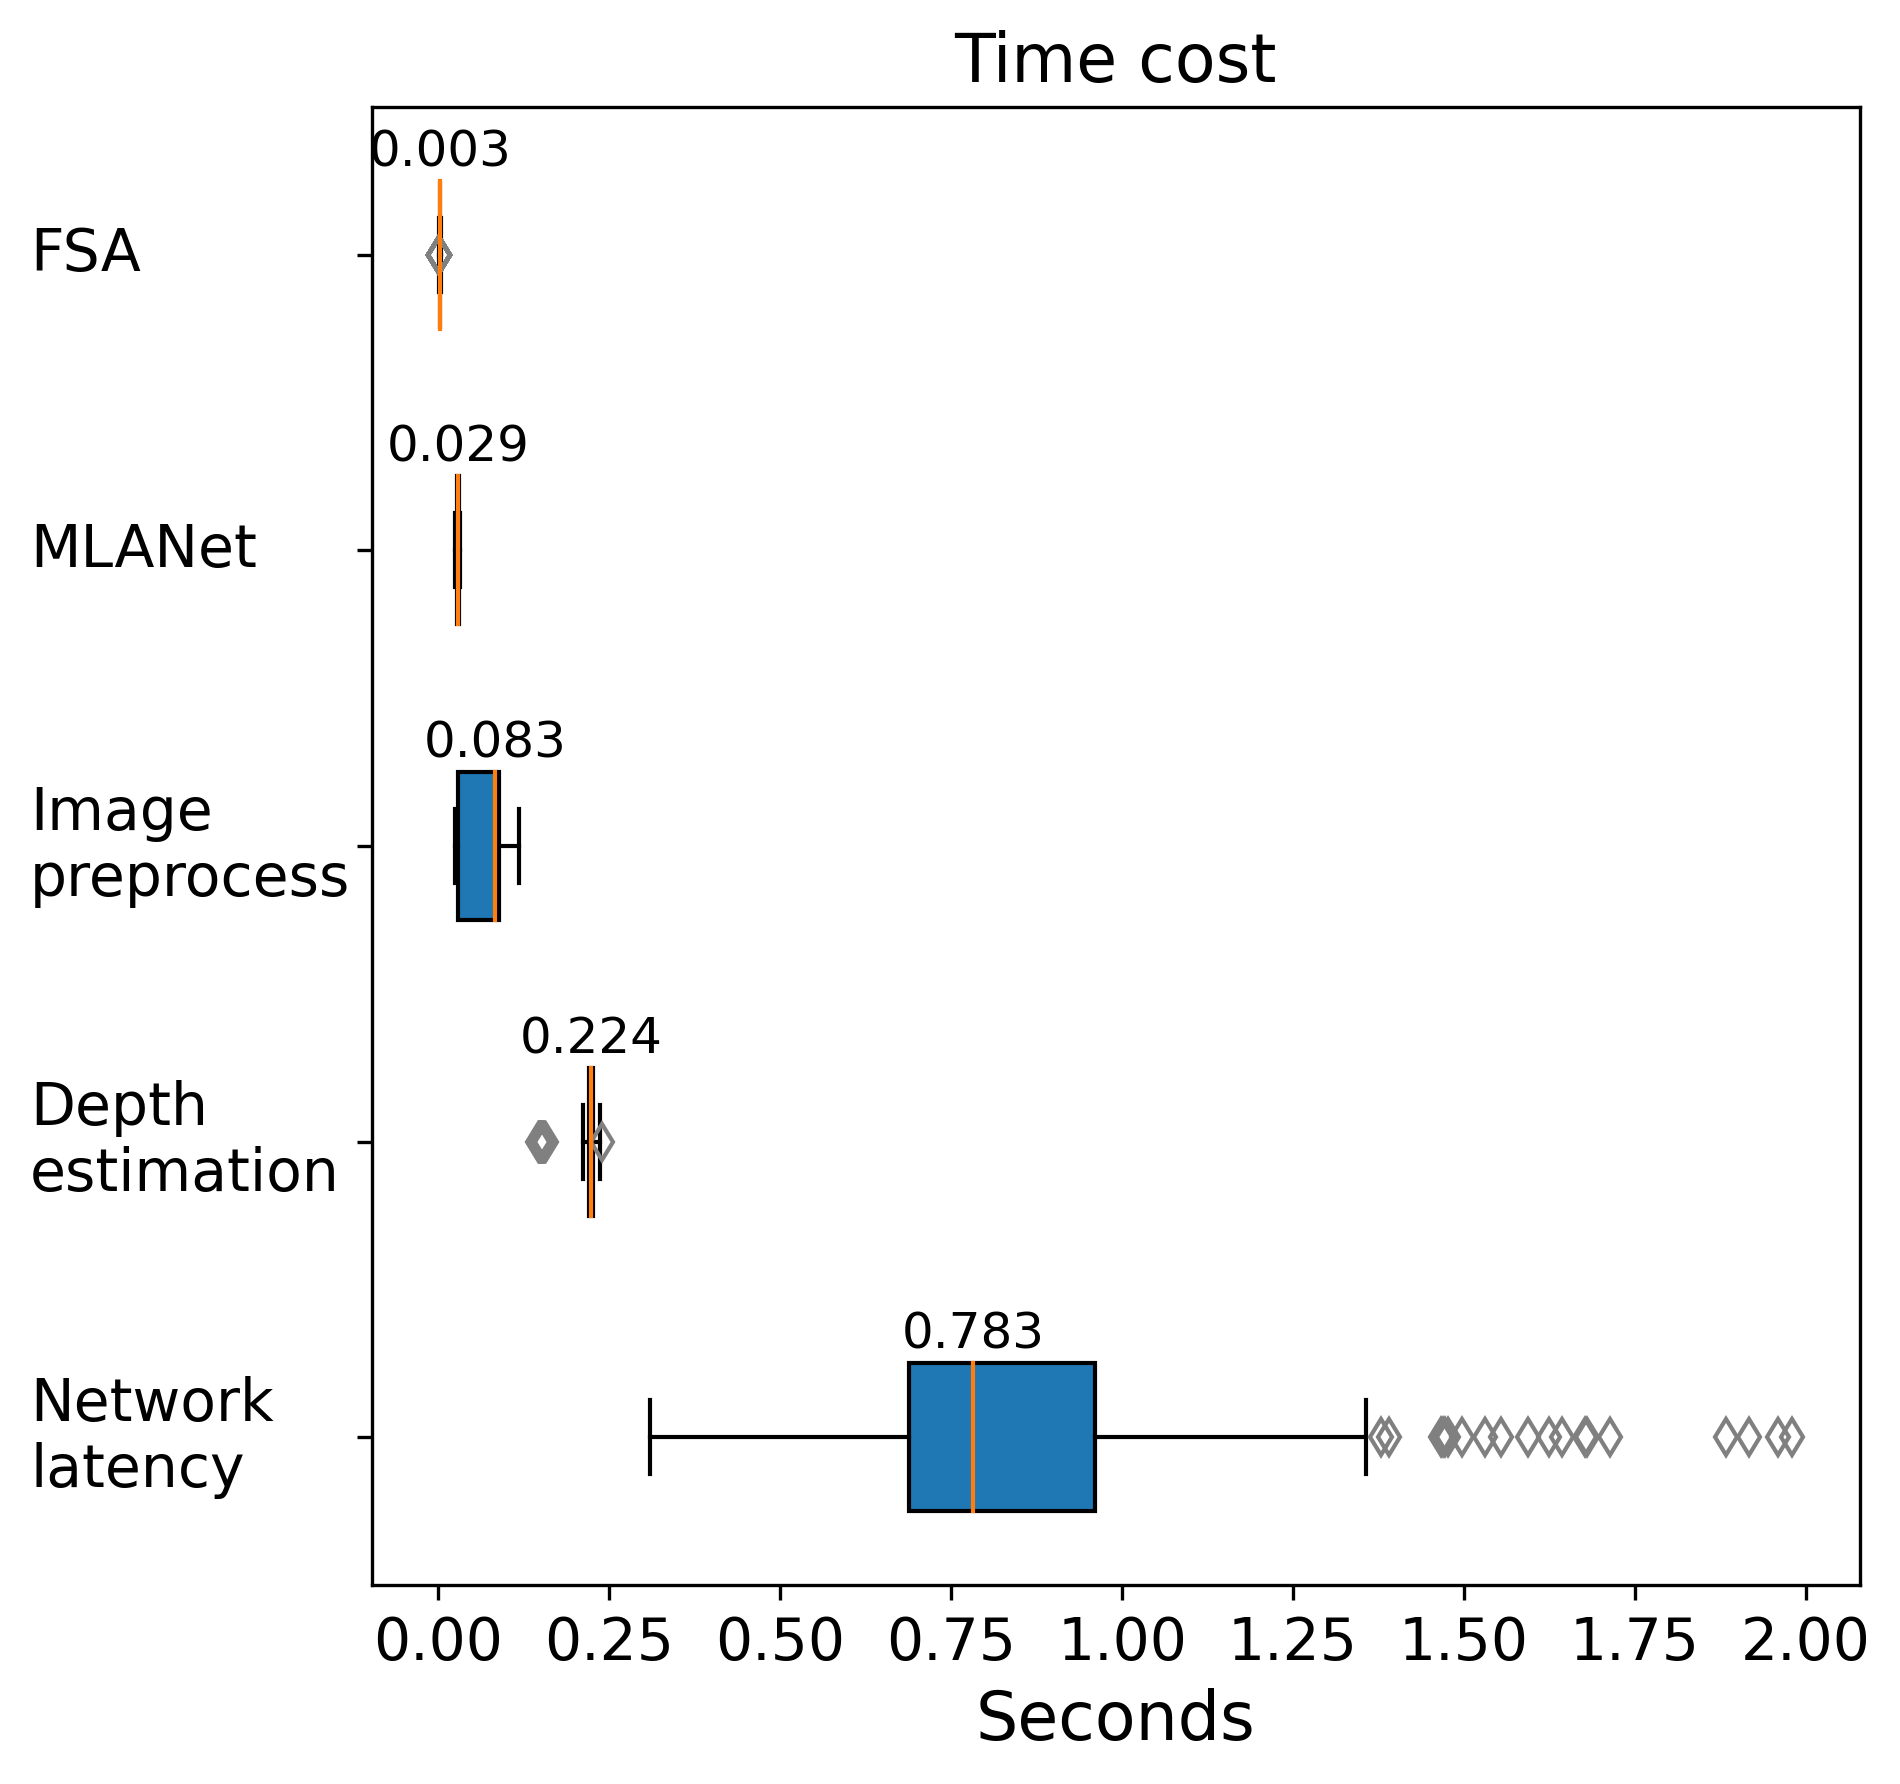

In [71]:
# plt.boxplot([policy_forward, depth_estimation])
all_data = [policy_forward, depth_estimation, rgb_preprocess, sub_segment, network_latency]
labels = ["MLANet", "Depth\nestimation", "Image\npreprocess", "FSA", "Network\nlatency"]
medians = [np.median(v) for v in all_data]
sorted_idx = np.argsort(medians)[::-1]
all_data = list(np.array(all_data)[sorted_idx])
labels = list(np.array(labels)[sorted_idx])
plt.figure(figsize=(6.4,6.4), dpi=300)
bplot1 = plt.boxplot(all_data,
                     vert=False,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,  # will be used to label x-ticks
                     flierprops={} # show mean values
        )
plt.title('Time cost', fontsize=16)
plt.xlabel("Seconds", fontsize=16)
ax = plt.gca()
ax.set_yticklabels(labels=labels, ha='left',va='center', position=(-0.21, 0), fontsize=14)
ax.get_xticklabels
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=14)
# plt.setp(ax.get_xticklabels(), rotation=-30, horizontalalignment='left')
plt.setp(bplot1['fliers'], markeredgecolor='gray', marker='d')
for line in bplot1['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+0.05, '%.3f' % x,
         horizontalalignment='center',fontsize=12) # draw above, centered
plt.savefig("time_analysis.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("time_analysis.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

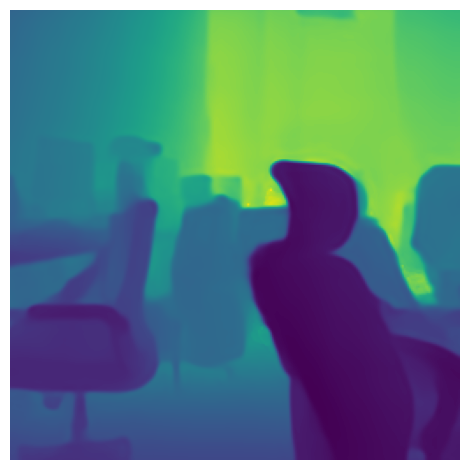

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
dep = Image.open("/share/home/tj90055/hzt/MLANet/data/vlntj-ce-extend-val/0/depth/67.png")
dep = np.array(dep, dtype=float)
plt.imshow(dep)
plt.axis(False)
plt.tight_layout()
plt.savefig("tmp.png",bbox_inches='tight', pad_inches=0)

In [21]:
labels

array(['FSA', 'MLANet w/o FSA', 'Image preprocess', 'Depth estimation',
       'Network latency'], dtype='<U16')

In [22]:
all_data.shape

(5, 453)